<h1>STROKE PREDICTION & ANALYSIS</h1>

![Stroke](https://blog.encompasshealth.com/wp-content/uploads/2020/09/did-you-have-a-stroke.jpg?w=700&h=400&crop=1)

<h3>In this notebook we'll deal with analyzing all factors that can lead to stroke. We'll compare what has more impact on stroke and after that we'll build a model to predict whether patient suffers of stroke. This is a classification problem and later we'll se which models we are going to use.</h3>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


# <span style="color:khaki">**Content**<span> 
- [Data Cleansing](#Data-Cleansing) <a href = '#Data-Cleansing'></a>
- [Label Encoding](#Label-Encoding) <a href = '#Label-Encoding'></a>
- [Data Analysis](#Data-Analysis) <a href = '#Data-Analysis'></a>
- [Models](#Models) <a href = '#Models'></a>
- [Oversampling](#OVERSAMPLING) <a href = '#OVERSAMPLING'></a>
- [Grid Search CV KNN](#KNNCV) <a href = '#KNNCV'></a>
- [KNN](#KNN) <a href = '#KNN'></a>
- [Grid Search CV Random Forest Classifier](#RFRCV) <a href = '#RFRCV'></a>
- [Random Forest Classifier](#RFR) <a href = '#KRFR'></a>







# <a id='Data-Cleansing' style="color:khaki" >**Data Cleansing**



Let's read our dataset and see what we have.

In [2]:
df = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


1. First we'll fill those null values in BMI column
2. We'll check all unique data in:
* gender
* work type
* residence type
* smoking status


In [4]:
df["bmi"] = df["bmi"].fillna(df["bmi"].mean())

print("Smoking Status:\n{}".format(df["smoking_status"].value_counts()))
print("\n\nGender:\n{}".format(df["gender"].value_counts()))
print("\n\nWork Type:\n{}".format(df["work_type"].value_counts()))
print("\n\nResidence Type:\n{}".format(df["Residence_type"].value_counts()))


Smoking Status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


Gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Work Type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Residence Type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


I'll remove gender == "other" because there's only 1 field

In [5]:
indexToDrop = df[df["gender"] == "Other"].index
df.drop(indexToDrop,inplace=True)
df["gender"].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

I'll also put "Formerly smoked" into "Smokes" group

In [6]:
df["smoking_status"] = df["smoking_status"].apply(lambda x: x.replace("formerly smoked","smokes"))
df["smoking_status"].value_counts()


never smoked    1892
smokes          1673
Unknown         1544
Name: smoking_status, dtype: int64

Now let's Label Encode our string columns.
* Gender
* Work type
* Residence type
* Ever Married
* Smoking Status

# <a id='Label-Encoding' style="color:khaki" >**Label Encoding**



In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

to_encode = ["gender","work_type","Residence_type","ever_married","smoking_status"]
def encode(colName):
    newName = colName + "_encoded"
    df[newName] = le.fit_transform(df[colName])
    return df

for x in to_encode:
    encode(x)
    
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_encoded,work_type_encoded,Residence_type_encoded,ever_married_encoded,smoking_status_encoded
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,smokes,1,1,2,1,1,2
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,0,3,0,1,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,1,2,0,1,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,0,2,1,1,2
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,0,3,0,1,1


# <a id='Data-Analysis' style="color:khaki" >**Data Analysis**



Let's import libraries for visualizations.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Let's start with basic countplot for Marriage effect on stroke

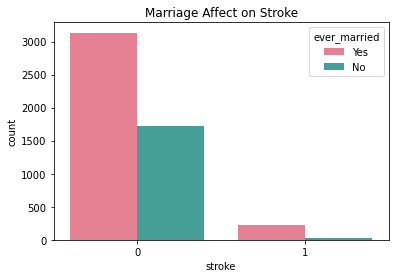

In [9]:
marriageStrokeAffect = sns.countplot(x="stroke",hue="ever_married",data=df,palette="husl")
marriageStrokeAffect.set_title("Marriage Affect on Stroke")
plt.show()

Let's have a closer look for those patients who had a stroke and their marriage status.

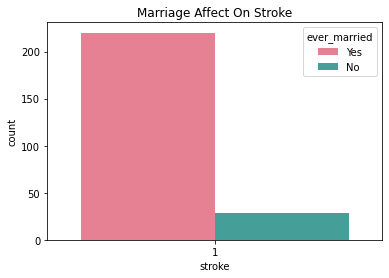

In [10]:
onlyStroke = df[df["stroke"] == 1]
marriageStrokeAffectOnlyStroke = sns.countplot(x="stroke",hue="ever_married",data=onlyStroke,palette="husl")
marriageStrokeAffectOnlyStroke.set_title("Marriage Affect On Stroke")
plt.show()

Let's see if age has any impact on stroke.

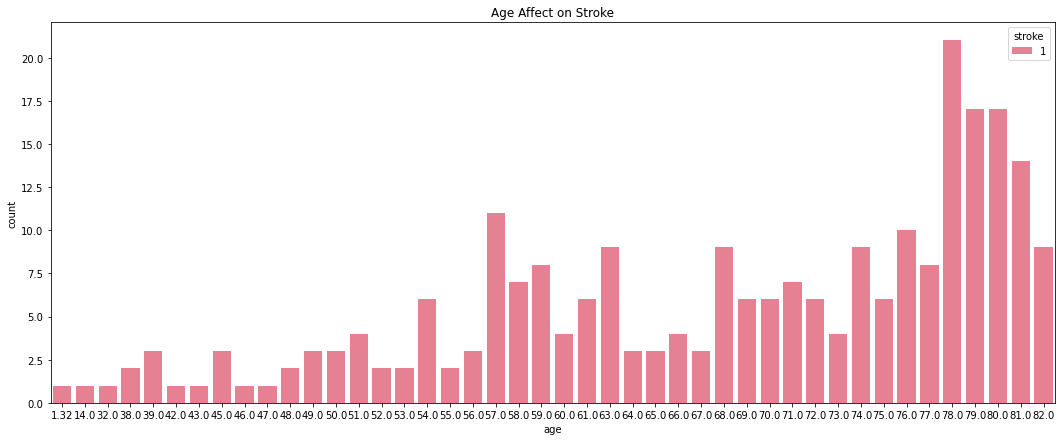

In [11]:
f, ax = plt.subplots(figsize=(18, 7))

ageStroke = sns.countplot(x="age",hue="stroke",data=onlyStroke,palette="husl")
ageStroke.set_title("Age Affect on Stroke")
plt.show()


Next plot will see which gender had more strokes.


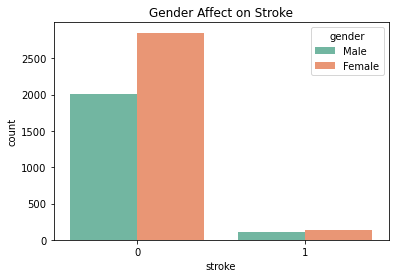

In [12]:
genderStroke = sns.countplot(x="stroke",hue="gender",data=df,palette="Set2")
genderStroke.set_title("Gender Affect on Stroke")
plt.show()

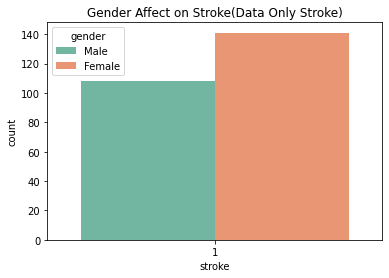

In [13]:
genderStroke = sns.countplot(x="stroke",hue="gender",data=onlyStroke,palette="Set2")
genderStroke.set_title("Gender Affect on Stroke(Data Only Stroke)")
plt.show()

In [14]:
ageGenderStrokeFig = px.bar(onlyStroke,x="age",y="stroke",color="gender",title="Age and Gender Affect on Stroke")
ageGenderStrokeFig.show()

In [15]:
heartDiseaseStroke = px.bar(onlyStroke,x="heart_disease",y="stroke",title="Heart Disease affect on Stroke")
heartDiseaseStroke.show()

In [16]:
heartDiseaseStrokeGender = px.bar(onlyStroke,x="heart_disease",y="stroke",color="gender",title="Heart Disease affect on Stroke")
heartDiseaseStrokeGender.show()


In [17]:
df["stroke_str"] = df["stroke"].apply(str)
bmiAgeStroke = px.scatter(df,x="age",y="bmi",color="stroke_str",color_discrete_sequence=px.colors.qualitative.Set3,
                          title="Age and BMI Affect on Stroke")
bmiAgeStroke.show()


In [18]:
glucoseAgeStroke = px.scatter(df,x="age",y="avg_glucose_level",color="stroke",
                              color_discrete_sequence=px.colors.qualitative.Set3,
                              title="Glucose Level and Age Affect on Stroke")
glucoseAgeStroke.show()

In [19]:
smokeStroke = px.bar(df,x="smoking_status",y="stroke",title="Smoke Affect on Stroke")
smokeStroke.show()

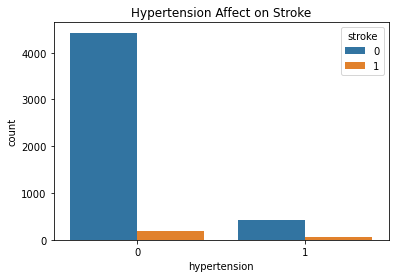

In [20]:
hypertensionStroke = sns.countplot(x="hypertension",hue="stroke",data=df)
hypertensionStroke.set_title("Hypertension Affect on Stroke")
plt.show()

In [21]:
workStroke = px.bar(df,x="work_type",y="stroke",color="gender",title="Work Type Affect on Stroke")
workStroke.show()

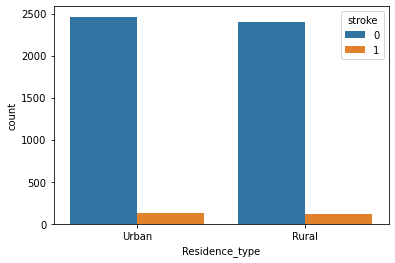

In [22]:
residenceStroke = sns.countplot(x="Residence_type",data=df,hue="stroke")
plt.show()

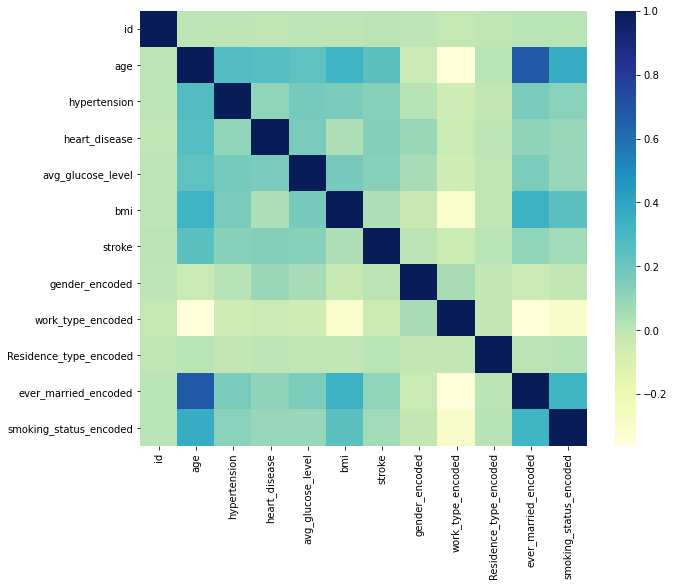

In [23]:
corr_df = df.corr()
f, ax = plt.subplots(figsize=(10, 8))

corr_vis = sns.heatmap(corr_df,cmap="YlGnBu")
plt.show()

# <a id='Models' style="color:khaki" >**Models**



Libraries

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

Features and target data

In [25]:
X = df[["age","hypertension","heart_disease","avg_glucose_level","bmi","gender_encoded","work_type_encoded","Residence_type_encoded","ever_married_encoded","smoking_status_encoded"]]
y = df["stroke"]

# <a id='OVERSAMPLING' style="color:khaki" >**Oversampling**



Our data is imbalanced - there is much more data for no stroke, then there is for stroke. So, we'll need to do oversample. I'll use SMOTE.

In [26]:
smk = SMOTE()
X_sam, y_sam = smk.fit_resample(X,y)

Old data

In [27]:
print(X.shape)
print(y.shape)


(5109, 10)
(5109,)


New data

In [28]:
print(X_sam.shape)
print(y_sam.shape)

(9720, 10)
(9720,)


In [29]:
X = X_sam[["age","hypertension","heart_disease","avg_glucose_level","bmi","gender_encoded","work_type_encoded","Residence_type_encoded","ever_married_encoded","smoking_status_encoded"]]
y = y_sam

Train test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# <a id='KNNCV' style="color:khaki" >**GRID SEARCH CV - KNN**



In [31]:
knn = KNeighborsClassifier()
parameters_knn = {"n_neighbors" : range(1,100,5), "weights" : ("uniform","distance"), "leaf_size" : range(10,100,10)}
gsKnn = GridSearchCV(knn,parameters_knn,scoring="accuracy")
gsKnn.fit(X_train,y_train)
print(gsKnn.best_score_)
print(gsKnn.best_estimator_)

0.9118159225482992
KNeighborsClassifier(leaf_size=10, n_neighbors=1)


# <a id='KNN' style="color:khaki" >**KNN**



Let's train our KNN with best parameters.

In [32]:
knn = KNeighborsClassifier(leaf_size=10, n_neighbors=1)
knn.fit(X_train,y_train)
knnPred = knn.predict(X_test)

print(classification_report(y_test,knnPred))
print(confusion_matrix(y_test,knnPred))


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      1467
           1       0.86      0.98      0.91      1449

    accuracy                           0.91      2916
   macro avg       0.92      0.91      0.91      2916
weighted avg       0.92      0.91      0.91      2916

[[1232  235]
 [  29 1420]]


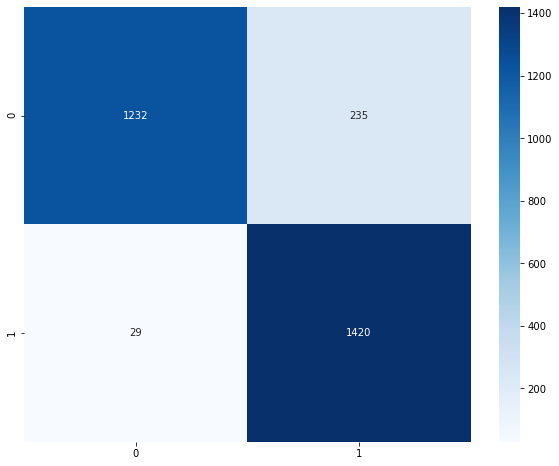

In [33]:
knnCfMatrix = confusion_matrix(y_test,knnPred)
f, ax = plt.subplots(figsize=(10, 8))
knnHeat = sns.heatmap(knnCfMatrix,annot=True,cmap="Blues",fmt="g")
plt.show()

# <a id='RFCCV' style="color:khaki" >**GRID SEARCH CV - RANDOM FOREST CLASSIFIER**



In [34]:
rfc = RandomForestClassifier()
parameters = {"n_estimators" : range(10,300,10), "criterion" : ("gini","entropy"), "max_features" : ("auto", "sqrt", "log2")}
gs = GridSearchCV(rfc,parameters,scoring="accuracy")
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_estimator_)

0.9357732203829364
RandomForestClassifier(max_features='log2', n_estimators=160)


# <a id='RFC' style="color:khaki" >**RANDOM FOREST CLASSIFIER**



Let's implement best parameters on Random Forest Classifier Model

In [35]:
rfc = RandomForestClassifier(max_features='sqrt', n_estimators=210)
rfc.fit(X_train,y_train)
rfcPred = rfc.predict(X_test)
print(classification_report(y_test,rfcPred))
print(confusion_matrix(y_test,rfcPred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1467
           1       0.92      0.97      0.94      1449

    accuracy                           0.94      2916
   macro avg       0.94      0.94      0.94      2916
weighted avg       0.94      0.94      0.94      2916

[[1340  127]
 [  49 1400]]


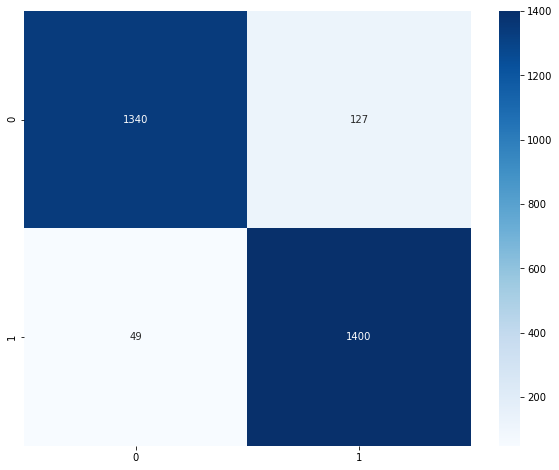

In [36]:
rfcCfMatrix = confusion_matrix(y_test,rfcPred)
f, ax = plt.subplots(figsize=(10, 8))
knnHeat = sns.heatmap(rfcCfMatrix,annot=True,cmap="Blues",fmt="g")
plt.show()

<h3> Upvote if you want to see more editing/model improvement/tuning on this code. :) </h3>